### Is gas more expensive in poor neighborhoods?
Driving around Oakland, it seemed to me that gas cost more in poor neighborhoods than rich ones. This notebook explores this hypothesis empirically. Spoiler alert: gas is actually _cheaper_ in poorer neighborhoods, at least in Los Angeles.

In [160]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr
import statsmodels.api as sm
from statsmodels.formula.api import ols
%matplotlib inline

In [161]:
def _parse(formatted_row):
    s= str(formatted_row[1])
    start = s.find("$") + 1
    end = start + 4
    price = s[start:end]
    while not price[-1].isdigit():
        price = price[:len(price)-1]
    price = float(price)
    start = s.find("located at") + len("located at") + 1
    end = s.find("border") - 2
    address = s[start:end]
    return price, address

def _extract_zip(address):
    try:
        zp = int(address.strip()[-5:])
    except ValueError:
        zp = -1
    return zp
        

def get_gas_prices(city, state, npages):
    urls = map(lambda x: "http://www.gaspricewatch.com/%s/%s/gas-prices/page-%d/2.htm" % \
               (state, city, x), range(1, npages+1))
    responses = [requests.get(url) for url in urls]
    soups = [BeautifulSoup(page.content, "lxml") for page in responses]
    try:
        summary = " ".join(city.split("-")) + ", " + state[0:2] + " Lowest Regular Gas Prices"

        rows=list()
        for i in xrange(len(soups)):
            tbl = soups[i].find("table", summary=summary)
            for row in tbl.findAll("tr"):
                rows.append(row)
        # 20 gas stations shown per page, plus a header
        header_idx = [0 + 21*k for k in xrange(npages)]
        rows = [rows[i] for i in xrange(len(rows)) if i not in header_idx]

        formatted_rows = list()
        for row in rows:
            formatted_rows.append(row.findAll("td"))
        gas_prices = pd.DataFrame(map(_parse, formatted_rows))
        gas_prices.rename(columns={0:"gas_price", 1:"address"}, inplace=True)
        gas_prices["ZIP5"] = map(_extract_zip, gas_prices.address)
        return gas_prices
    except ValueError:
        return soups

In [162]:
gas_prices_LA = get_gas_prices("Los-Angeles", "CA-california", 15)

I started with Oakland, but found an insigificant positive effect, so I picked a larger city in California to get more power.

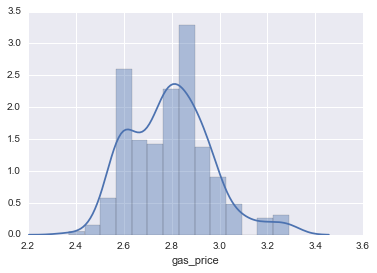

In [164]:
sns.distplot(gas_prices_LA.gas_price)

get median income from Census. This is for California ONLY, and comes from the American Communities Survey

In [165]:
census_data = pd.read_csv("/Users/timothysweetser/git/gas-prices/raw_data/ACS_14_5YR_DP03_with_ann.csv",
                                   usecols=["HC01_VC85", "GEO.id2", "GEO.display-label"],
                          low_memory=False)
census_data.rename(columns=dict(zip(census_data.columns, census_data.ix[0, :])), inplace=True)
census_data.rename(columns={census_data.columns[-1]:"median_income"}, inplace=True)
census_data.drop([0], axis=0, inplace=True)
census_data["Id2"] = census_data["Id2"].astype(int)
census_data["median_income"] = [x if x != "-" else np.nan for x in census_data["median_income"]]
census_data["median_income"] = census_data["median_income"].astype(float)
census_data.head()

,Id2,Geography,median_income
1,89010,ZCTA5 89010,35000.0
2,89019,ZCTA5 89019,37632.0
3,89060,ZCTA5 89060,40726.0
4,89061,ZCTA5 89061,55096.0
5,89439,ZCTA5 89439,59275.0


In [166]:
# 5-digit Zip code uniquely identifies each row
census_data.Id2.nunique() == len(census_data)

True

In [167]:
combined = gas_prices_LA.merge(census_data, 'inner', left_on="ZIP5", right_on="Id2")
combined = combined[combined["median_income"] < 110000] 
# exclude 1 very high income ZIP code

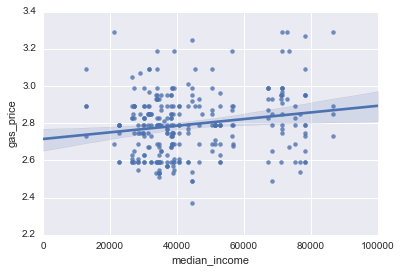

In [168]:
sns.regplot("median_income", "gas_price", data=combined)

In [169]:
pearsonr(combined["median_income"], combined["gas_price"])

(0.17872817789871331, 0.0024149836635892589)

This is the opposite of what I expected! The effect is very slight, but gas costs __less__ in low-income neighborhoods.

In [170]:
mod = ols("gas_price ~ median_income", data=combined).fit()
print mod.summary()

                            OLS Regression Results                            
Dep. Variable:              gas_price   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     9.371
Date:                Sat, 04 Jun 2016   Prob (F-statistic):            0.00241
Time:                        16:06:22   Log-Likelihood:                 108.28
No. Observations:                 286   AIC:                            -212.6
Df Residuals:                     284   BIC:                            -205.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept         2.7153      0.028     98.662

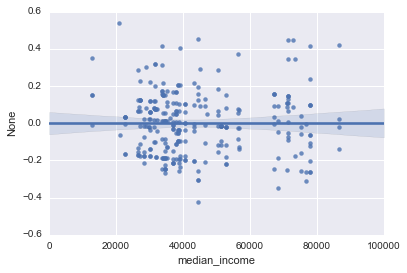

In [171]:
# heteroskedasticity is not a problem
sns.regplot(combined["median_income"], mod.resid)